In [1]:
import ee

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn

from pprint import pprint
import os

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/G_drive')

# cp tokens
!mkdir /root/.config/earthengine/
!cp '/content/G_drive/MyDrive/Colab Notebooks/Google_Earth_Engine_tokes/credentials' /root/.config/earthengine/credentials 

# authenticate earthengine api
ee.Initialize()

Mounted at /content/G_drive


In [3]:
# change cwd
cwd = '/content/G_drive/MyDrive/Colab Notebooks/Paper_3/Earth_Engine_codes/Step_1_UNET_predict_future_urbanization'
os.chdir(cwd)

In [4]:
# the provinces in NCP
province_NCP_map = dict(zip(['北京市','天津市','河南省','河北省','山东省','安徽省','江苏省'],
                ['Beijing','Tianjin','Henan','Hebei','Shandong','Anhui','Jiangsu']))

In [5]:
# read data
data_path = '../../Data/06_Yearbook/GDP_Population'
GDP_China = pd.read_csv(f"{data_path}/yearbook_GDP_China.csv")
Population_China = pd.read_csv(f"{data_path}/yearbook_population_China.csv")

# reshape to long df
GDP_China = pd.DataFrame(GDP_China.set_index('Province').stack()).reset_index()
GDP_China.columns = ['Province','year','GDP']
GDP_China['year'] = GDP_China['year'].astype('int16')

Population_China = pd.DataFrame(Population_China.set_index('Province').stack()).reset_index()
Population_China.columns = ['Province','year','Pop']
Population_China['year'] = Population_China['year'].astype('int16')

In [6]:
# function to compute the total GDP/Pop and the provincial ratio of ecah record
def sum_and_compute_ratio(df,ratio_type='GDP_ratio'):

  # groupby year and compute sum
  df_sum = df.groupby('year').sum()
  df_sum.reset_index(inplace=True)
  df_sum['year'] = df_sum['year'].astype('int16')

  # compute the privince ratio to the sum
  ratios = []
  val = 'GDP' if ratio_type == 'GDP_ratio' else 'Pop'
  for idx,row in df.iterrows():
    # get the sum record
    sum = df_sum[df_sum['year']==row['year']][val].values[0]
    ratio = row[val]/sum
    ratios.append(ratio)
  
  # append ratios to df
  df[ratio_type] = ratios

  # select only the NCP provinces
  df = df[df['Province'].isin(province_NCP_map.keys())]

  # map CN to EN
  df['Province'] = df['Province'].map(province_NCP_map)

  return df_sum[['year',val]],df

In [7]:
# get the NCP records and concat dfs
GDP_sum, GDP_NCP = sum_and_compute_ratio(GDP_China)
Pop_sum, Pop_NCP = sum_and_compute_ratio(Population_China,'Pop_ratio')

# merge GDP and Pop records
GDP_Pop_sum = pd.merge(left=GDP_sum,right=Pop_sum,on=['year'])
GDP_Pop_NCP = pd.merge(left=GDP_NCP,right=Pop_NCP,on=['Province','year'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Segregate future GDP/Pop to each province

#### 1) first reshape df

In [8]:
# load SSP GDP-ppp and Population
SSP_GDP = pd.read_csv(f'{data_path}/SSP_GDP_ppp.csv')
SSP_Pop = pd.read_csv(f'{data_path}/SSP_Population.csv')

# get the shared cols
same_cols = set(SSP_GDP.columns)&set(SSP_Pop.columns)
same_cols = sorted(same_cols)
same_cols.remove('2010.1')
same_cols = ['Scenario'] + same_cols[:-1]

SSP_GDP = SSP_GDP[same_cols]
SSP_Pop = SSP_Pop[same_cols]

# reshape df to long format
SSP_GDP_long = SSP_GDP.set_index(['Scenario']).stack().reset_index()
SSP_GDP_long.columns = ['Scenario','year','GDP']
SSP_GDP_long['year'] = SSP_GDP_long['year'].astype('int16')

SSP_Pop_long = SSP_Pop.set_index(['Scenario']).stack().reset_index()
SSP_Pop_long.columns = ['Scenario','year','Pop']
SSP_Pop_long['year'] = SSP_Pop_long['year'].astype('int16')

In [9]:
SSP_Pop_long

,Scenario,year,Pop
0,SSP1,1980,983.171
1,SSP1,1985,1056.579
2,SSP1,1990,1145.195
3,SSP1,1995,1213.987
4,SSP1,2000,1269.117
...,...,...,...
125,SSP5,2080,880.994
126,SSP5,2085,821.370
127,SSP5,2090,762.385
128,SSP5,2095,703.630


#### 2) then build a linear regression to convert yearbook_GDP to SSP_GDP

In [10]:
# connect yearbook_GDP with SSP_GDP
ssp_1990_2020_GDP = SSP_GDP_long[(SSP_GDP_long['year']>1989)&(SSP_GDP_long['year']<2021)]
ssp_1990_2020_GDP = ssp_1990_2020_GDP.groupby('year').mean()
ssp_1990_2020_GDP.reset_index(inplace=True)

GDP_SSP_yearbook = pd.merge(left=ssp_1990_2020_GDP,right=GDP_sum,on='year')
GDP_SSP_yearbook.columns = ['year','GDP_SSP','GDP_yearbook']

In [11]:
GDP_SSP_yearbook

,year,GDP_SSP,GDP_yearbook
0,1995,2227.9610,57421.8
1,2000,3368.0670,98134.4
2,2005,5364.2510,189085.1
3,2008,7566.7550,320202.7
4,2010,9122.2370,414670.5
5,2015,13866.7332,693642.0
6,2020,20455.1698,1012415.2


In [12]:
# built the linear regression
y = GDP_SSP_yearbook['GDP_yearbook']
X = GDP_SSP_yearbook['GDP_SSP']

# add a constant column to X, so to get intercept
X = sm.add_constant(X)

# construct the model
mod = sm.OLS(y, X)
res = mod.fit()

# make predictions on original
coef_SSP = res.params['GDP_SSP']
constant = res.params['const']

# report r2
print(res.rsquared)

0.9978254312118242


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


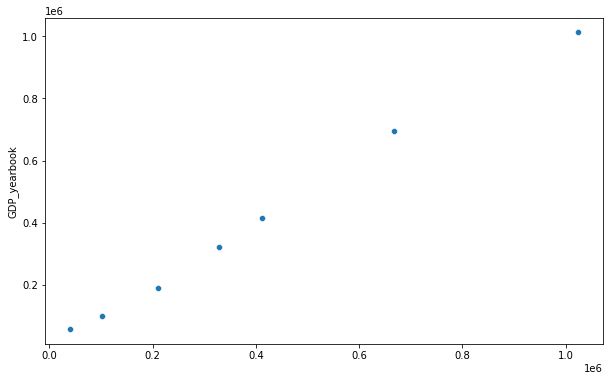

In [13]:
# plot the tranformed GDP_ssp with GDP_yearbook
plt.figure(figsize=(10,6))
sns.scatterplot(x=res.predict(X),y=GDP_SSP_yearbook['GDP_yearbook'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


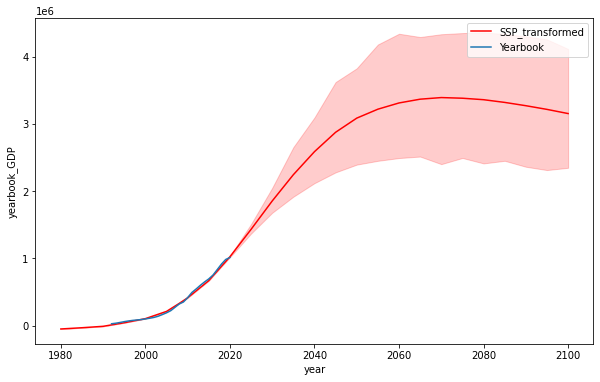

In [14]:
# plot the trasformed GDP
SSP_GDP_long['yearbook_GDP'] = res.predict(sm.add_constant(SSP_GDP_long['GDP']))

plt.figure(figsize=(10,6))
sns.lineplot(data=SSP_GDP_long,x='year',y='yearbook_GDP',color='red',label='SSP_transformed')
sns.lineplot(data=GDP_sum,x='year',y='GDP',label='Yearbook')

In [15]:
# merge dfs to get SSP_GDP_Pop
SSP_GDP_Pop = pd.merge(left=SSP_GDP_long,right=SSP_Pop_long,on=['Scenario','year'])
SSP_GDP_Pop['yearbook_Pop'] = SSP_GDP_Pop['Pop'] * 100 # SSP-Pop (million); Yearbook-Pop (10K)
SSP_GDP_Pop

,Scenario,year,GDP,yearbook_GDP,Pop,yearbook_Pop
0,SSP1,1980,514.118,-5.147770e+04,983.171,98317.1
1,SSP1,1985,855.625,-3.307255e+04,1056.579,105657.9
2,SSP1,1990,1249.453,-1.184760e+04,1145.195,114519.5
3,SSP1,1995,2227.961,4.088804e+04,1213.987,121398.7
4,SSP1,2000,3368.067,1.023328e+05,1269.117,126911.7
...,...,...,...,...,...,...
125,SSP5,2080,100306.728,5.326739e+06,880.994,88099.4
126,SSP5,2085,100054.625,5.313152e+06,821.370,82137.0
127,SSP5,2090,99454.000,5.280782e+06,762.385,76238.5
128,SSP5,2095,98525.084,5.230719e+06,703.630,70363.0


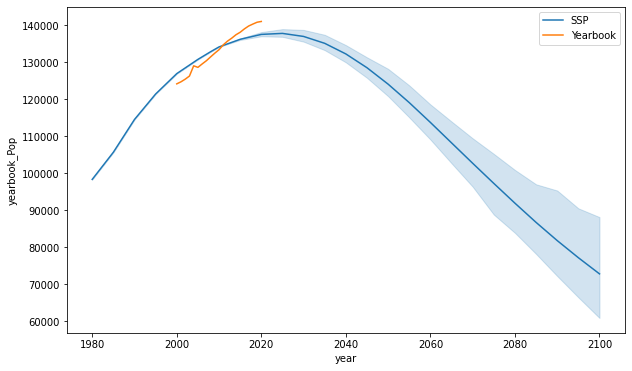

In [16]:
# plot the Pop_SSP with Pop_yearbook
plt.figure(figsize=(10,6))
sns.lineplot(data=SSP_GDP_Pop,x='year',y='yearbook_Pop',label='SSP')
sns.lineplot(data=Pop_sum,x='year',y='Pop',label='Yearbook')

#### 3) then segregate the future total GDP using the GDP-ratio of 2020

##### Question: --> dose the GDP/Pop ratio of each province have been changed much for the last 20 yrs?

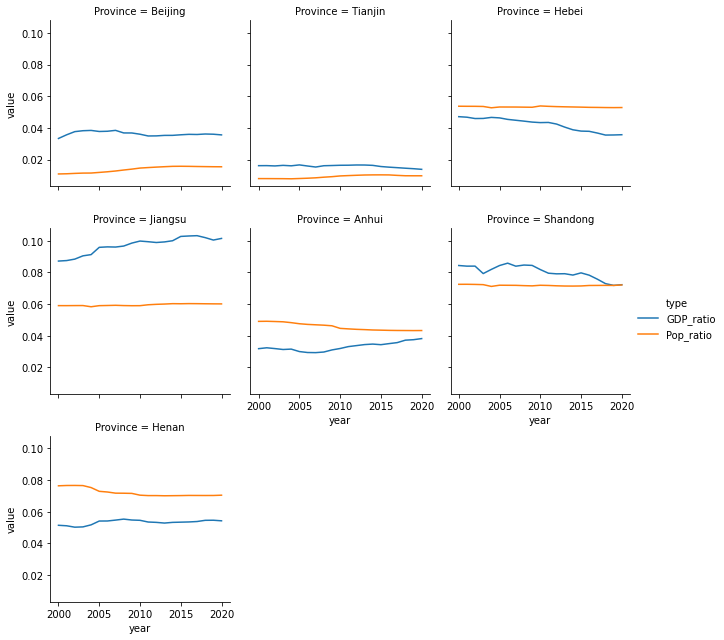

In [ ]:
# Question: --> dose the GDP/Pop ratio of each province have been changed much for the last 20 yrs?
GDP_Pop_ratio_stack = pd.DataFrame(GDP_Pop_NCP[['Province','year','GDP_ratio','Pop_ratio']].set_index(['Province','year']).stack()).reset_index()
GDP_Pop_ratio_stack.columns = ['Province','year','type','value']

g = sns.FacetGrid(data=GDP_Pop_ratio_stack,col='Province',hue='type', col_wrap=3)
g.map(sns.lineplot,'year','value')
g.add_legend()

In [ ]:
# try linear model to extrapolate the GDP/Pop ratios to 2100

pred_dfs = []
R2 = {}

# loop through each province
for p in GDP_Pop_ratio_stack['Province'].unique():
  df_filtered = GDP_Pop_ratio_stack[GDP_Pop_ratio_stack['Province'] == p]

  # loop through GDP/Pop
  for val in ['GDP_ratio','Pop_ratio']:
    df_val = df_filtered[df_filtered['type'] == val]

    y = df_val['value']
    X = df_val['year']

    # add a constant column to X, so to get intercept
    X = sm.add_constant(X)

    # construct the model
    mod = sm.OLS(y, X)
    res = mod.fit()

    # make predictions on original
    coef_val = res.params['year']
    constant = res.params['const']

    # predict to the future
    future_years = np.array(range(2020,2101))
    preds = future_years * coef_val + constant

    # construct df
    pred_df = pd.DataFrame({'Province':[p]*len(future_years), 
                  'year':future_years, 
                  'type':[val]*len(future_years),
                  'value':preds})
    
    pred_dfs.append(pred_df)

    # record r2
    R2[p,val] = res.rsquared

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


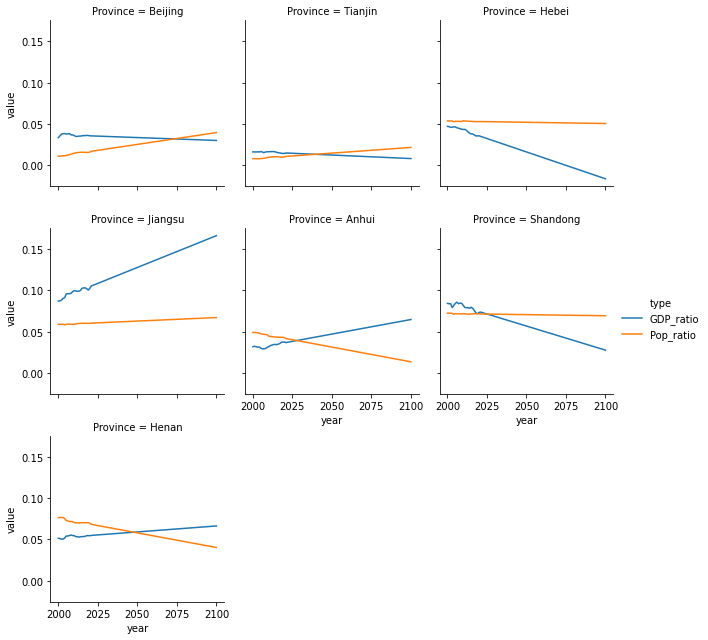

In [ ]:
# make the predicted GDP/Pop shares given 
GDP_Pop_ratio_stack_extrapolate = pd.concat([GDP_Pop_ratio_stack] + pred_dfs)
GDP_Pop_ratio_stack_extrapolate.reset_index(inplace=True)

g = sns.FacetGrid(data=GDP_Pop_ratio_stack_extrapolate,col='Province',hue='type', col_wrap=3)
g.map(sns.lineplot,'year','value')
g.add_legend()

##### Use the 2020 GDP/Pop ratio and assumes the future ratio remain unchanged

In [ ]:
# get the 2020 GDP/Pop ratios
GDP_Pop_ratio_2020 = GDP_Pop_ratio_stack[GDP_Pop_ratio_stack['year']==2020]
privince = GDP_Pop_ratio_2020['Province'].unique().tolist()
GDP_ratio_2020 = GDP_Pop_ratio_2020[GDP_Pop_ratio_2020['type']=='GDP_ratio']['value'].tolist()
Pop_ratio_2020 = GDP_Pop_ratio_2020[GDP_Pop_ratio_2020['type']=='Pop_ratio']['value'].tolist()

# get the future GDP/Pop
SSP_GDP_Pop_future = SSP_GDP_Pop[SSP_GDP_Pop['year']>2019][['Scenario','year','yearbook_GDP','yearbook_Pop']]

# segregate future China-GDP/Pop to specific province
SSP_GDP_Pop_future['Province'] = [privince] * len(SSP_GDP_Pop_future)
SSP_GDP_Pop_future['GDP_ratio'] = [GDP_ratio_2020] * len(SSP_GDP_Pop_future)
SSP_GDP_Pop_future['Pop_ratio'] = [Pop_ratio_2020] * len(SSP_GDP_Pop_future)

# explode to get long formate df
SSP_GDP_Pop_future = SSP_GDP_Pop_future.explode(['Province','GDP_ratio','Pop_ratio'])

# get the future GDP/Pop of each province
SSP_GDP_Pop_future['GDP'] = SSP_GDP_Pop_future['yearbook_GDP'] * SSP_GDP_Pop_future['GDP_ratio']
SSP_GDP_Pop_future['Pop'] = SSP_GDP_Pop_future['yearbook_Pop'] * SSP_GDP_Pop_future['Pop_ratio']

# select only necessay cols
SSP_GDP_Pop_future = SSP_GDP_Pop_future[['Scenario','year','Province','GDP','Pop']]

# concat future with historical yearbook records
GDP_Pop_NCP['Scenario'] = 'Historical'
SSP_GDP_Pop_future = pd.concat([GDP_Pop_NCP,SSP_GDP_Pop_future.reset_index()],axis=0,join='inner')
SSP_GDP_Pop_future.reset_index(inplace=True,drop=True)

# save to disk
SSP_GDP_Pop_future.to_csv('./result_csv/SSP_GDP_Pop_future.csv',index=False)

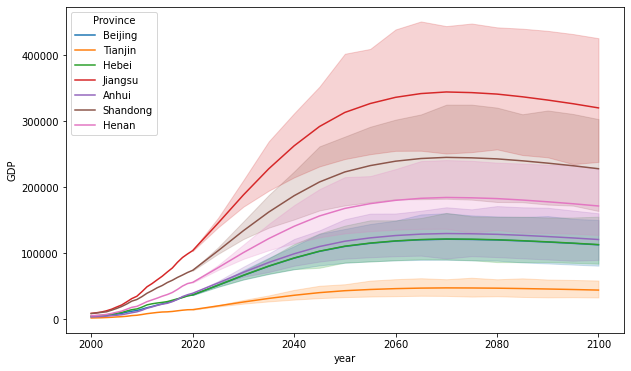

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(data=SSP_GDP_Pop_future,x='year',y='GDP',hue='Province')

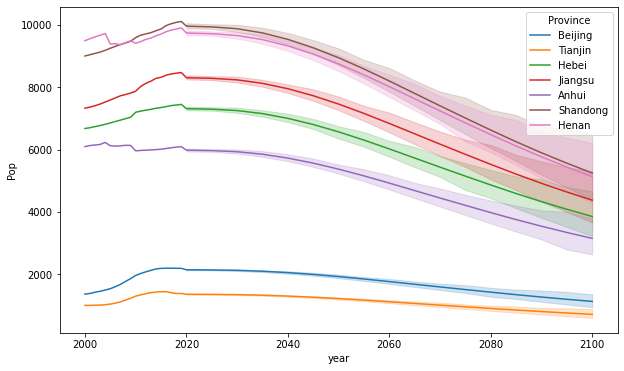

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(data=SSP_GDP_Pop_future,x='year',y='Pop',hue='Province')

### Compute the urban area of each province since 1990

#### 1) extract historical urban pixel count

In [17]:
# load admin boundary and the historical urban maps
NCP_Province = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")
urban = ee.Image("users/wangjinzhulala/China_built_up/06_temporal_corrected_classification/Mosaic_only_forward_China_huadong_sample_ensemble")

In [18]:
# zonal statistics using admin shp on urban img
zonal_stats = urban.reduceRegions(collection = NCP_Province, 
                  reducer = ee.Reducer.frequencyHistogram(), 
                  scale=30, 
                  tileScale=2).getInfo()

In [19]:
# formating stats
stats_tuple = [(i['properties']['EN_Name'],i['properties']['histogram'].keys(),i['properties']['histogram'].values()) 
          for i in zonal_stats['features']]

stats_df = pd.DataFrame(stats_tuple).explode([1,2])
stats_df = stats_df[stats_df[1]!='0']
stats_df.columns = ['Province','year','count']

stats_df['year'] = stats_df['year'].astype('int16')
stats_df['count'] = stats_df['count'].astype('float')
stats_df = stats_df.sort_values(['Province','year'],ascending=[True,False])

# compuete the urban pixel count of each year
total_count = stats_df.groupby('Province')['count'].cumsum()
stats_cumsum = stats_df.copy()
stats_cumsum['year'] = list(range(1992,2020,3)) * stats_df['Province'].nunique()
stats_cumsum['count'] = total_count
stats_cumsum = stats_cumsum.reset_index(drop=True)

In [20]:
# connet GDP/Pop to urban pixels count
GDP_Pop_NCP_urban_count = pd.merge(left=GDP_Pop_NCP,right=stats_cumsum,on=['Province','year'])

# save csv to disk
GDP_Pop_NCP_urban_count.to_csv('./result_csv/GDP_Pop_NCP_urban_count.csv',index=False)
GDP_Pop_NCP_urban_count.sample(5)

,Province,year,GDP,GDP_ratio,Pop,Pop_ratio,count
21,Jiangsu,2019,98656.8,0.100432,8469.0,0.060147,2.572632e+07
11,Tianjin,2007,4158.4,0.015363,1115.0,0.008551,2.417528e+06
38,Shandong,2010,33922.5,0.081806,9588.0,0.071882,2.558333e+07
4,Beijing,2007,10425.5,0.038516,1676.0,0.012853,3.318160e+06
18,Hebei,2007,12152.9,0.044898,6943.0,0.053247,1.524168e+07


#### 2)-1 linear regression to build the mode count~GDP-Pop

In [ ]:
# function to fit the linear model and make predictions
def linear_model(df):

  y = df['count']
  X = df[['GDP','Pop']]

  # add a constant column to X, so to get intercept
  X = sm.add_constant(X)

  # construct the model
  mod = sm.OLS(y, X)
  res = mod.fit()

  # make predictions on original
  df['count_pred'] = res.predict(X)

  return res,df

From below plot we can see that Beijing has a bad fit between pred and true values. So, its better to try "Mixed models" to perform the regression. Essenstialy, a mixed model refers to treat each province with a seperat intercept and slop given the regrestion of "count ~ GDP + Pop + GDP*Pop"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


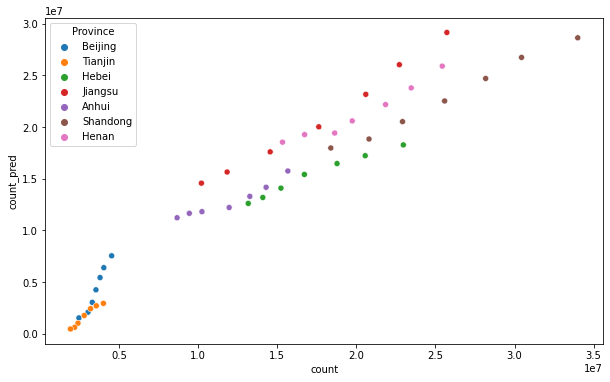

In [ ]:
# fit original data with the model
model,GDP_Pop_NCP_urban_count_fit = linear_model(GDP_Pop_NCP_urban_count.copy())

# predict
plt.figure(figsize=(10,6))
sns.scatterplot(data=GDP_Pop_NCP_urban_count_fit,x='count',y='count_pred',hue='Province')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


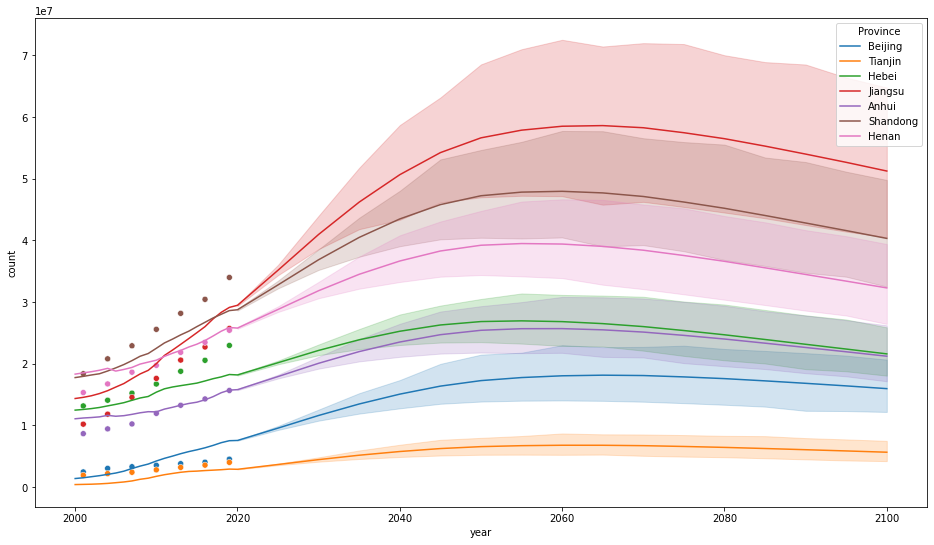

In [ ]:
SSP_GDP_Pop_future_pred_linear = SSP_GDP_Pop_future.copy()

# add a constant column to X, so to get intercept
X = SSP_GDP_Pop_future_pred_linear[['GDP','Pop']]
X = sm.add_constant(X)

# make predictions on original
SSP_GDP_Pop_future_pred_linear['count_pred'] = model.predict(X)

# plot to see the prediction 
plt.figure(figsize=(16,9))
sns.scatterplot(data=GDP_Pop_NCP_urban_count,x='year',y='count',hue='Province',legend=False)
sns.lineplot(data=SSP_GDP_Pop_future_pred_linear,x='year',y='count_pred',hue='Province')

#### 2)-2 Mixed linear regression to build the mode count~GDP-Pop

In [ ]:
# see the computation in ./R_code/R_1_linear_mixed_model.R

In [23]:
# load prediction csv
SSP_GDP_Pop_future_pred = pd.read_csv('./result_csv/SSP_GDP_Pop_future_pred.csv')
SSP_GDP_Pop_future_pred

,Province,year,GDP,Pop,Scenario,count_pred,brms_future,brms_future_low,brms_future_high
0,Beijing,2020,36102.600000,2189.000000,Historical,4.073877e+06,4.721984e+06,3.332410e+06,6.147079e+06
1,Beijing,2019,35445.100000,2190.000000,Historical,4.052236e+06,4.696801e+06,3.331851e+06,6.128981e+06
2,Beijing,2018,33106.000000,2192.000000,Historical,3.973296e+06,4.538574e+06,3.237727e+06,5.836471e+06
3,Beijing,2017,29883.000000,2194.000000,Historical,3.863582e+06,4.343095e+06,3.105167e+06,5.616983e+06
4,Beijing,2016,27041.200000,2195.000000,Historical,3.765890e+06,4.215339e+06,3.023931e+06,5.440970e+06
...,...,...,...,...,...,...,...,...,...
737,Hebei,2100,184361.789888,3411.728643,SSP5,5.798455e+07,6.215160e+07,4.544932e+07,9.109145e+07
738,Jiangsu,2100,523034.523682,3874.762019,SSP5,8.707517e+07,8.426283e+07,4.451385e+07,1.044681e+08
739,Anhui,2100,196957.614431,2790.541716,SSP5,4.637384e+07,4.851599e+07,3.945723e+07,6.047351e+07
740,Shandong,2100,372365.304202,4646.331948,SSP5,8.586648e+07,8.832780e+07,6.172311e+07,1.108338e+08


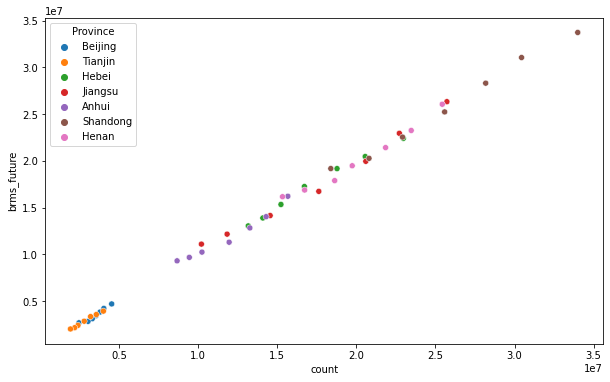

In [27]:
# merge pred with true
SSP_GDP_Pop_count_pred_ture = GDP_Pop_NCP_urban_count.merge(SSP_GDP_Pop_future_pred,on=['Province', 'year'])

# plot the comparision between pred and true
plt.figure(figsize=(10,6))
sns.scatterplot(data=SSP_GDP_Pop_count_pred_ture,x='count',y='brms_future',hue='Province')

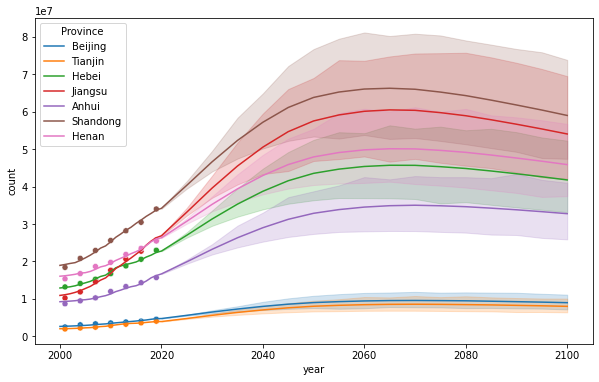

In [28]:
# plot to see the prediction 
plt.figure(figsize=(10,6))
sns.scatterplot(data=GDP_Pop_NCP_urban_count,x='year',y='count',hue='Province',legend=False)
sns.lineplot(data=SSP_GDP_Pop_future_pred,x='year',y='brms_future',hue='Province')

#### 2)-3 built seperate regresion for each province

In [ ]:
original_preds = []
model_pred = {}
# loop through each province
for p in GDP_Pop_NCP_urban_count['Province'].unique():
  df_filtered = GDP_Pop_NCP_urban_count[GDP_Pop_NCP_urban_count['Province'] == p]

  # Built the model
  y = df_filtered['count']
  X = df_filtered[['GDP','Pop']]

  # add a constant column to X, so to get intercept
  X = sm.add_constant(X)

  # construct the model
  mod = sm.OLS(y, X)
  res = mod.fit()
  model_pred[p] = res

  # make predictions on original data
  pred = res.predict(X).tolist()
  df_filtered['pred'] = pred
  original_preds.append(df_filtered)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


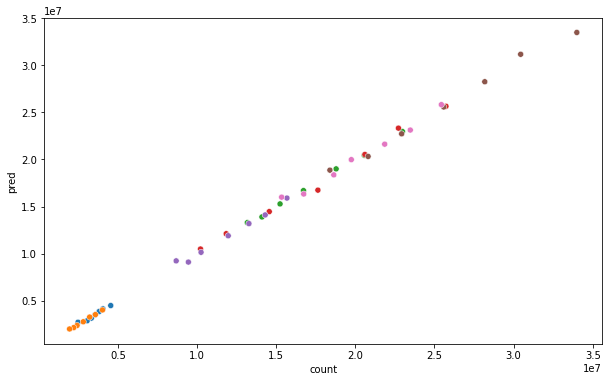

In [ ]:
# check the model performance on original data
original_preds_df = pd.concat(original_preds)

# plot to see the prediction 
plt.figure(figsize=(10,6))
sns.scatterplot(data=original_preds_df,x='count',y='pred',hue='Province',legend=False)

In [ ]:
future_preds = []
for p in SSP_GDP_Pop_future['Province'].unique():
  for ssp in SSP_GDP_Pop_future['Scenario'].unique():

    # get the model fitted from historical data
    res = model_pred[p]

    # filter the df
    df_filtered = SSP_GDP_Pop_future[(SSP_GDP_Pop_future['Province'] == p)&
                       (SSP_GDP_Pop_future['Scenario'] == ssp)]
    
    # pred the future
    X_to_pred = pd.DataFrame({'GDP':df_filtered['GDP'],'Pop':df_filtered['Pop']})
    X_to_pred = sm.add_constant(X_to_pred)
    df_filtered['count_pred'] = res.predict(X_to_pred).tolist()

    future_preds.append(df_filtered)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


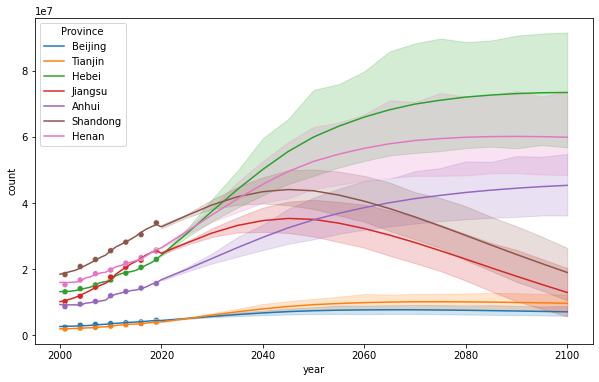

In [ ]:
# check the model performance on original data
future_preds_df = pd.concat(future_preds)

# plot to see the prediction 
plt.figure(figsize=(10,6))
sns.scatterplot(data=GDP_Pop_NCP_urban_count,x='year',y='count',hue='Province',legend=False)
sns.lineplot(data=future_preds_df,x='year',y='count_pred',hue='Province')

#### 2)-4 Transforme provinces as dummny variables and build a linear regression

In [ ]:
# Transforme province name to dummies
Dummy_provinces_urban_count = GDP_Pop_NCP_urban_count.copy()
Province_dummies = Dummy_provinces_urban_count['Province'].str.get_dummies()

Dummy_provinces_urban_count = pd.concat([Dummy_provinces_urban_count,Province_dummies],1)
Dummy_provinces_urban_count.head()

In [ ]:
# built linear model using dummies
y = Dummy_provinces_urban_count['count']
X = Dummy_provinces_urban_count[['GDP',  'Pop', 'Anhui', 'Beijing','Hebei', 
                  'Henan', 'Jiangsu', 'Shandong','Tianjin']]

# add a constant column to X, so to get intercept
X = sm.add_constant(X)

# construct the model
mod = sm.OLS(y, X)
model_dummy = mod.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# predict to the future
dummy_pred = SSP_GDP_Pop_future.copy()
dummy_names = dummy_pred['Province'].str.get_dummies()

dummy_pred = pd.concat([dummy_pred,dummy_names],1)

X = dummy_pred[['GDP',  'Pop', 'Anhui', 'Beijing','Hebei', 'Henan', 'Jiangsu', 'Shandong','Tianjin']]

# add a constant column to X, so to get intercept
X = sm.add_constant(X)

dummy_pred['count_pred'] = model_dummy.predict(X)

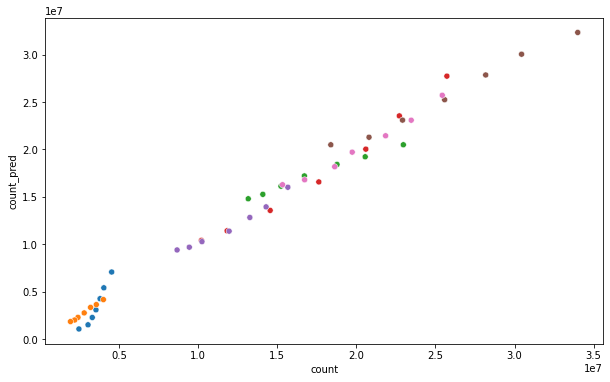

In [ ]:
pred_actual_df = dummy_pred.merge(GDP_Pop_NCP_urban_count,on=['Province','year'])

plt.figure(figsize=(10,6))
sns.scatterplot(data=pred_actual_df,x='count',y='count_pred',hue='Province',legend=False)

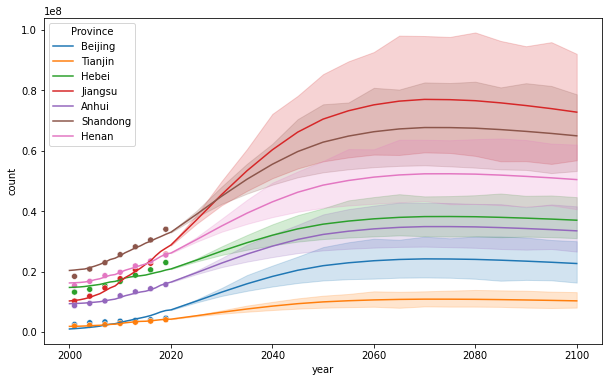

In [ ]:
# plot to see the prediction 
plt.figure(figsize=(10,6))
sns.scatterplot(data=GDP_Pop_NCP_urban_count,x='year',y='count',hue='Province',legend=False)
sns.lineplot(data=dummy_pred,x='year',y='count_pred',hue='Province')